In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [39]:
model_names = [

    "ew_lo", "mvo_ls_mle_mle", "rpo_ls_mle_mle_cs2006", "rpo_ls_mle_mle_cs2006",
    "rbmvo_ls_cbb", "rbmvo_ls_nobb", "rbmvo_ls_sb",
    "rbmvog_ls_cbb", "rbmvog_ls_nobb", "rbmvog_ls_sb"

]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [40]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [41]:

all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
ew_lo,9.557377,17.214801,0.555184,0.649588,-4.722567,-43.241254,0.531953
mvo_ls_mle_mle,2.043442,18.388642,0.111125,0.131709,-27.441344,-46.466797,0.500957
rpo_ls_mle_mle_cs2006,1.950775,9.967128,0.195721,0.261204,-11.437594,-23.185857,0.486212
rbmvo_ls_cbb,2.350498,10.024448,0.234477,0.301464,-8.754633,-29.933546,0.509984
rbmvo_ls_nobb,-0.038727,10.112686,-0.003830,-0.004706,-11.574355,-32.994126,0.505230
rbmvo_ls_sb,1.595300,12.475053,0.127879,0.162299,-11.865149,-20.559317,0.490016
rbmvog_ls_cbb,13.716648,45.186871,0.303554,0.450544,-36.467890,-85.732021,0.486529
rbmvog_ls_nobb,8.627873,43.539282,0.198163,0.295117,-23.336881,-66.213145,0.481775
rbmvog_ls_sb,11.932073,45.657685,0.261338,0.363751,-32.783985,-68.267446,0.477021


In [42]:
print(all_stats_df.reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
                index &      E[R] &    Std(R) &    Sharpe &   Sortino &      AvgDD &      MaxDD &  \% Positive Ret. \\
\midrule
                ew\_lo &  9.557377 & 17.214801 &  0.555184 &  0.649588 &  -4.722567 & -43.241254 &         0.531953 \\
       mvo\_ls\_mle\_mle &  2.043442 & 18.388642 &  0.111125 &  0.131709 & -27.441344 & -46.466797 &         0.500957 \\
rpo\_ls\_mle\_mle\_cs2006 &  1.950775 &  9.967128 &  0.195721 &  0.261204 & -11.437594 & -23.185857 &         0.486212 \\
         rbmvo\_ls\_cbb &  2.350498 & 10.024448 &  0.234477 &  0.301464 &  -8.754633 & -29.933546 &         0.509984 \\
        rbmvo\_ls\_nobb & -0.038727 & 10.112686 & -0.003830 & -0.004706 & -11.574355 & -32.994126 &         0.505230 \\
          rbmvo\_ls\_sb &  1.595300 & 12.475053 &  0.127879 &  0.162299 & -11.865149 & -20.559317 &         0.490016 \\
        rbmvog\_ls\_cbb & 13.716648 & 45.186871 &  0.303554 &  0.450544 & -36.467890 & -85.732021 &         0.48652

## 2) Cummulative Returns of the Portfolios

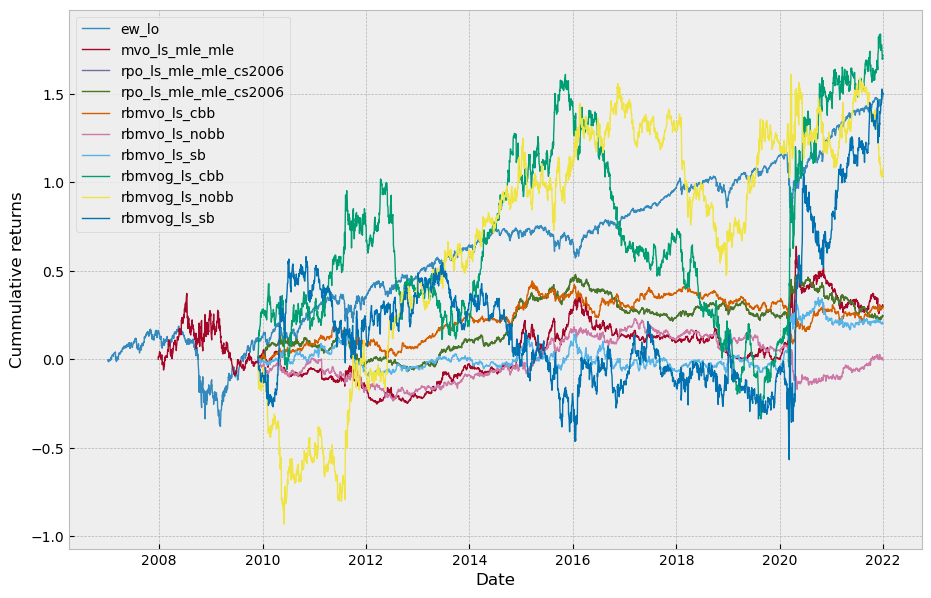

In [43]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].loc["2007-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Boxplot with the Sharpe Ratio for each Monte Carlo Sample

## 4) Forecast Comparison - Diebold-Mariano Test